In [1]:
#起手式
import numpy as np 
import math
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import timm
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.optim.lr_scheduler import SequentialLR

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from PIL import Image

#随机种子
def set_seed(seed):
    seed = int(seed)
    if seed < 0 or seed > (2**32 - 1):
        raise ValueError("Seed must be between 0 and 2**32 - 1")
    else:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
set_seed(16)

#当前设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'使用{device}训练')

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

使用cuda训练


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std=(0.229,0.224,0.225)),
])
class Dataset():
    def __init__(self, df, transform, scaler_target):
        self.samples = list(df.itertuples(index=False))
        self.image_dir = "/kaggle/input/csiro-biomass"
        self.targets = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
        self.transform = transform
        self.scaler_target = scaler_target

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]

        img_path = os.path.join(self.image_dir, row.image_path)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        target = torch.tensor([getattr(row, t) for t in self.targets], dtype=torch.float32)
        target = torch.tensor(self.scaler_target.transform([target.numpy()])[0], dtype=torch.float32)

        return image, target

In [3]:
#读取文件 并统计图片对应标签值
df = pd.read_csv("/kaggle/input/csiro-biomass/train.csv")
df = df[["image_path", "target_name", "target"]]
df = df.pivot_table(index=["image_path"],columns='target_name',values="target").reset_index()
print('文件读取成功',df.head(5))
#转换结构 列为target_name 值为target

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

#目标值缩放 避免梯度爆炸
scaler_target = StandardScaler()
targets=['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
scaler_target.fit(df_train[targets].values)

#数据集和加载器
batch_size = 64

train_dataset = Dataset(df_train, transform, scaler_target)
test_dataset = Dataset(df_test, transform, scaler_target)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=2)


文件读取成功 target_name              image_path  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  \
0            train/ID1011485656.jpg        0.0000     31.9984      16.2751   
1            train/ID1012260530.jpg        0.0000      0.0000       7.6000   
2            train/ID1025234388.jpg        6.0500      0.0000       0.0000   
3            train/ID1028611175.jpg        0.0000     30.9703      24.2376   
4            train/ID1035947949.jpg        0.4343     23.2239      10.5261   

target_name  Dry_Total_g    GDM_g  
0                48.2735  16.2750  
1                 7.6000   7.6000  
2                 6.0500   6.0500  
3                55.2079  24.2376  
4                34.1844  10.9605  


In [4]:
#模型
class ViTBase16(nn.Module):
    def __init__(self):

        super(ViTBase16, self).__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        self.model.head = nn.Linear(self.model.head.in_features, 5)

    def forward(self, x):
        x = self.model(x)
        return x


In [5]:
#混合精度
from torch.amp import autocast, GradScaler 
scaler = GradScaler()
print("启用混合精度训练")

def train():
    model.train()
    loss_sum = 0.0

    for x , Y in train_dataloader:
        x , Y= x.to(device) , Y.to(device)

        optimizer.zero_grad()
        # pred = model(x)
        # loss=loss_fn(pred,Y)
        # print(loss)
        # optimizer.step
        
        with autocast(device):
            pred = model(x)
            loss = loss_fn(pred, Y)
            #print(loss)
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()
        
        loss_sum += loss.item()

    return loss_sum / len(train_dataloader)

启用混合精度训练


In [6]:
def test():
    model.eval()
    loss_sum = 0.0

    with torch.no_grad():
        for x , Y in test_dataloader:
            x , Y= x.to(device),Y.to(device)
            
            pred = model(x)
            loss = loss_fn(pred, Y)
            loss_sum += loss.item()

    return loss_sum / len(test_dataloader)

In [7]:
#释放内存
import gc
torch.cuda.empty_cache()
gc.collect()

#定义模型
model = ViTBase16()
#多gpu运行
model = model.to('cuda:0')
if torch.cuda.device_count() > 1:
    print(f"使用 {torch.cuda.device_count()} 个GPU")
    model = torch.nn.DataParallel(model)
else:
    model.to(device)

#损失函数
loss_fn = nn.MSELoss()
epoch = 200
# lr = 1e-4
# optimizer = optim.Adam(model.parameters(),lr=lr)

optimizer = optim.SGD(model.parameters(),
                      lr=0.005,              
                      momentum=0.9
                      #weight_decay=5e-4
                     )
#学习率预热
warmup_step= int(epoch * 0.1)  #预热步数
warmup = LinearLR(optimizer,
                  start_factor=0.01,
                  total_iters=warmup_step)
#余弦退火
cosin = CosineAnnealingLR(optimizer,
                          T_max=epoch - warmup_step
                         #eta_min=1e-6
                         )
#调度器
scheduler = SequentialLR(optimizer, 
                         schedulers=[warmup,cosin],#预热然后余弦退火
                         milestones=[warmup_step]
                        )#切换

min_loss = np.inf
best_model = model #最优模型

train_loss_list=[]
test_loss_list=[]
lr_list=[]

#耐心
n= 10
if n < int(epoch*0.3): n= int(epoch*0.3)
print("早停耐心：",n)

for i in range(epoch):
    train_loss=train()
    test_loss=test()
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    scheduler.step()  # 更新学习率
    
    lr_list.append(scheduler.get_last_lr()[0])
    
    print(f"第{i+1}/{epoch}迭代 | 训练损失:{train_loss} | 测试损失值:{test_loss}")
    print(f"| 当前学习率{scheduler.get_last_lr()[0]:6f} |")
    
    if min_loss >= test_loss:
        min_loss = test_loss
        best_model=model
        if 10 < int(epoch*0.3): 
            n= int(epoch*0.3)  #恢复耐心
        else:n=10
            
    else:
        #早停
        n-=1
        if n <=0:
            epoch = i+1
            print('早停')
            break
torch.save(model.state_dict(), 'VIT—CSIRO')
print("保存模型：VIT—CSIRO")


使用 2 个GPU
早停耐心： 60
第1/200迭代 | 训练损失:1.2430252432823181 | 测试损失值:0.762394905090332
| 当前学习率0.000297 |
第2/200迭代 | 训练损失:1.2723251581192017 | 测试损失值:0.7484981417655945
| 当前学习率0.000545 |
第3/200迭代 | 训练损失:1.1215086817741393 | 测试损失值:1.0278691053390503
| 当前学习率0.000793 |
第4/200迭代 | 训练损失:1.0216554760932923 | 测试损失值:0.8892275989055634
| 当前学习率0.001040 |
第5/200迭代 | 训练损失:0.9302072286605835 | 测试损失值:0.9887737929821014
| 当前学习率0.001288 |
第6/200迭代 | 训练损失:0.9400421500205993 | 测试损失值:0.6696152091026306
| 当前学习率0.001535 |
第7/200迭代 | 训练损失:0.8629693150520324 | 测试损失值:0.7426877021789551
| 当前学习率0.001783 |
第8/200迭代 | 训练损失:0.8243360042572021 | 测试损失值:0.7099922597408295
| 当前学习率0.002030 |
第9/200迭代 | 训练损失:0.7984086394309997 | 测试损失值:0.6902456879615784
| 当前学习率0.002278 |
第10/200迭代 | 训练损失:0.8564302206039429 | 测试损失值:0.7539334893226624
| 当前学习率0.002525 |
第11/200迭代 | 训练损失:0.9353720664978027 | 测试损失值:0.5682492256164551
| 当前学习率0.002773 |
第12/200迭代 | 训练损失:0.8086835384368897 | 测试损失值:0.6964873820543289
| 当前学习率0.003020 |
第13/200迭代 | 训练损失:0.

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


第21/200迭代 | 训练损失:0.9309540033340454 | 测试损失值:0.7940693795681
| 当前学习率0.005000 |
第22/200迭代 | 训练损失:0.9072074294090271 | 测试损失值:0.9168432950973511
| 当前学习率0.004998 |
第23/200迭代 | 训练损失:0.7905752301216126 | 测试损失值:1.3159548044204712
| 当前学习率0.004997 |
第24/200迭代 | 训练损失:0.7644511699676514 | 测试损失值:0.89154914021492
| 当前学习率0.004994 |
第25/200迭代 | 训练损失:0.8596126556396484 | 测试损失值:1.1733728051185608
| 当前学习率0.004990 |
第26/200迭代 | 训练损失:0.8000896096229553 | 测试损失值:0.8333362936973572
| 当前学习率0.004986 |
第27/200迭代 | 训练损失:0.7716960310935974 | 测试损失值:0.6286029368638992
| 当前学习率0.004981 |
第28/200迭代 | 训练损失:0.8296290636062622 | 测试损失值:0.8524544537067413
| 当前学习率0.004976 |
第29/200迭代 | 训练损失:0.9137253284454345 | 测试损失值:0.7988936901092529
| 当前学习率0.004969 |
第30/200迭代 | 训练损失:0.8534339547157288 | 测试损失值:1.15516996383667
| 当前学习率0.004962 |
第31/200迭代 | 训练损失:0.984140419960022 | 测试损失值:0.8972861170768738
| 当前学习率0.004954 |
第32/200迭代 | 训练损失:0.9638195276260376 | 测试损失值:1.4732733964920044
| 当前学习率0.004945 |
第33/200迭代 | 训练损失:0.853018867969513 |

Text(0.5, 1.0, 'lr')

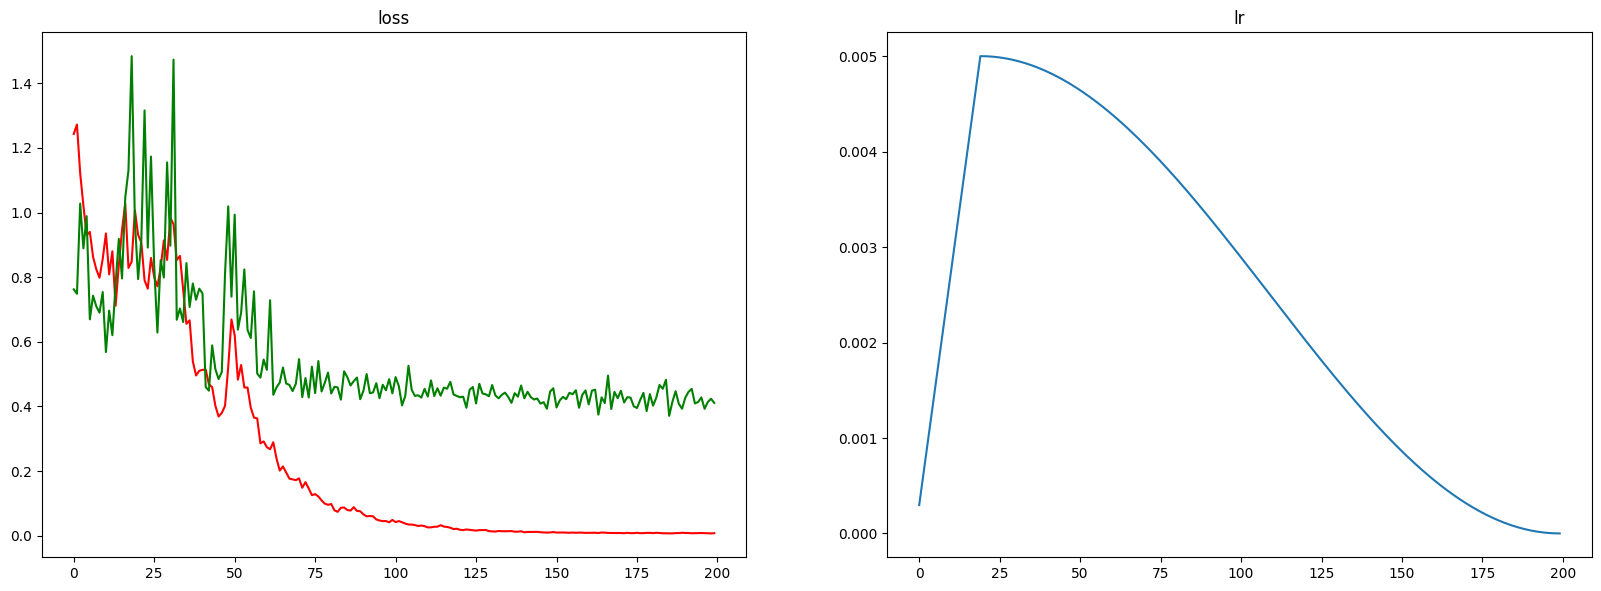

In [8]:
x=[i for i in range(epoch)]

plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.plot(x,train_loss_list,color='red',label='train_loss')
plt.plot(x,test_loss_list,color='green',label='test_loss')
plt.title("loss")

plt.subplot(2,2,2)
plt.plot(lr_list)
plt.title("lr")

In [9]:
df_test = pd.read_csv('/kaggle/input/csiro-biomass/test.csv')
test_path = df_test["image_path"].values.tolist()
test_target = df_test["target_name"].values.tolist()

res = []
with torch.no_grad():
    for img_path,target in zip(test_path,test_target):
        img_path = os.path.join('/kaggle/input/csiro-biomass', img_path)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).to(device).unsqueeze(0)

        preds = best_model(image)
        preds = scaler_target.inverse_transform(preds.detach().cpu())
        preds=preds.reshape(-1)
        if target == 'Dry_Clover_g':
            res.append(preds[0])
        elif target == 'Dry_Dead_g':
            res.append(preds[1])
        elif target == 'Dry_Green_g':
            res.append(preds[2])
        elif target == 'Dry_Total_g':
            res.append(preds[3])
        else: #GDM_g
            res.append(preds[4])

#输出
submission = pd.DataFrame({'sample_id':df_test['sample_id'],'target':res})
submission.to_csv('submission.csv', index = False)
print(submission)

                    sample_id     target
0  ID1001187975__Dry_Clover_g   0.957693
1    ID1001187975__Dry_Dead_g  24.621775
2   ID1001187975__Dry_Green_g   9.844155
3   ID1001187975__Dry_Total_g  34.446157
4         ID1001187975__GDM_g  18.527838
